In [44]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
from scipy import sparse as sp
from time import time
import scipy.sparse.linalg as spla
from math import sqrt
import simulated_data as simd
import data_strm_subclass as dssb
import streaming_subclass as stsb
import plot_functions as pf
import pickle
from pandas import DataFrame as df

In [2]:
def expvar(X, W, xnorm2=None):
    '''
    Calculate the explained variance of X
    Inputs:
        X: n x d array-like
        W: d x k array-like
        xnorm2: optional float, the squared frobenius norm of X. This is often
            calculated in other applications and can thus be provided.
    '''
    
    if xnorm2 is None:
        xnorm2 = la.norm(X, ord='fro')**2
    return la.norm(X.dot(W), ord='fro')**2 / xnorm2

# ADAM and RMSProp

We want to see how ADAM and RMSProp behave in the streaming PCA setting (which includes a normalization step not included in standard SGD). 
We draw on the datasets and code from "AdaOja: Adaptive Learning Rates for Streaming PCA" by Amelia Henriksen and Rachel Ward.
Note that we consider three datasets: sparse, bag-of-words "Kos" data; dense "CIFAR" data; and synthetic spiked covariance data with noise parameter $0.25$. 

Note that in our original experiments prior to writing the paper for AdaOja, we mostly considered the recommended parameters and implementation for ADAM and RMSProp. As we demonstrate below, the recommended parameters and implementation for these methods do not produce good results in this setting. This new exploration expands beyond our previous work and comes up with some interesting--and more relevant--results.

## Loading the Data

In [3]:
# Load Small bag of words data
kos_n, kos_d, kos_nnz, kos_dense, kos_SpX, kos_norm2 = dssb.get_bagX('docword.kos.txt') 
nips_n, nips_d, nips_nnz, nips_dense, nips_SpX, nips_norm2 = dssb.get_bagX('docword.nips.txt')
enr_n, enr_d, enr_nnz, enr_dense, enr_SpX, enr_norm2 = dssb.get_bagX('docword.enron.txt')

In [4]:
k = 10
# Obtain true ExpVar for Small Bag-of-words data
v_kos = spla.svds((kos_SpX.T.dot(kos_SpX)).astype(float), k=k)[2].T
kos_expvar = la.norm(kos_SpX.dot(v_kos), ord='fro')**2 / kos_norm2

v_nips = spla.svds((nips_SpX.T.dot(nips_SpX)).astype(float), k=k)[2].T
nips_expvar = la.norm(nips_SpX.dot(v_nips), ord='fro')**2 / nips_norm2

#v_enr = spla.svds((enr_SpX.T.dot(enr_SpX)).astype(float), k=k)[2].T
#enr_expvar = la.norm(enr_SpX.dot(v_enr), ord='fro')**2 / enr_norm2

In [5]:
# Load the CIFAR dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load the CIFAR data
db = []
for i in range(1, 6):
    db.append(unpickle('data_batch_' + str(i))[b'data'])
CIFAR = np.vstack(db)

# Centralize the CIFAR data
CIFAR_sc = CIFAR - CIFAR.mean(axis=0)
CIFAR_norm2 = la.norm(CIFAR_sc, ord='fro')**2
v_CIFAR = la.eigh(np.cov(CIFAR.T))[1][:,::-1]

CIFAR_evar = expvar(CIFAR_sc, v_CIFAR[:,:k], xnorm2=CIFAR_norm2)

In [6]:
# Initialize Synthetic Data
n = 10000
B = 1
d = 1000
k = 10
sigma = 0.25
cov, w, A0, syn = simd.spiked_covariance(n, d, k, sigma=sigma)
V = la.eigh(np.cov(syn.T))[1][:,::-1][:,:k]
syn_evar = expvar(syn, V)
syn_norm2 = la.norm(syn, ord='fro')**2

## Recommended parameters 

The recommended parameters for RMSProp are $\gamma = 0.9, \eta = 0.001$
The recommended parameters for ADAM are $\beta_1 =0.9, \beta_2 = 0.999, \epsilon = 10^{-8}, \eta=0.001$.
We proceed following the original algorithms using these parameters.
The original algorithms are also designed for the single update step rather than the block update step, so we begin by setting $B=1$.


## Single Value, Vector and Matrix cases
RMSProp and ADAM were originally proposed for the single vector case. Therefore, we can consider three different kinds of update steps for the case $k > 1$. 

1. Single Value
$$\text{RMSProp: } b_t \leftarrow \gamma b_{t-1} + (1 - \gamma) * ||G_t||_2^2 $$
$$\text{ADAM: } b_t \leftarrow \frac{\beta_2 b_{t-1} + (1 - \beta_2) ||G_t||_2^2}{1-\beta_2^{Bt}} $$

2. Vector Case
$$\text{RMSProp: } b_t^{(i)} \leftarrow \gamma b_{t-1}^{(i)} + (1 - \gamma) * ||G_t^{(i)}||_2^2 $$
$$\text{ADAM: } b_t^{(i)} \leftarrow \frac{\beta_2 b_{t-1}^{(i)} + (1 - \beta_2) ||G_t^{(i)}||_2^2}{1-\beta_2^{Bt}} $$

3. Matrix Case
$$\text{RMSProp: } b_t^{(i,j)} \leftarrow \gamma b_{t-1}^{(i,j)} + (1 - \gamma) * (G_t^{(i,j)})^2 $$
$$\text{ADAM: } b_t^{(i,j)} \leftarrow \frac{\beta_2 b_{t-1}^{(i,j)} + (1 - \beta_2) (G_t^{(i,j)})^2}{1-\beta_2^{Bt}} $$

In [7]:
def comp_b0_dim(spca0, spca1, spca2, dataname, methodname, true_evar=None):
    '''
    Plotting function to compare the accuracy evolution for the single, 
    vector and matrix versions of the desired streaming pca method.
    '''
    plt.plot(spca0.acc_indices, spca0.accQ, label='Single Case')
    plt.plot(spca1.acc_indices, spca1.accQ, label='Vector Case')
    plt.plot(spca2.acc_indices, spca2.accQ, label='Matrix Case')
    
    if true_evar is not None:
        assert true_evar >= 0 and true_evar <=1, "The true explained variance should be a float > 0"
        plt.plot(spca0.acc_indices, np.ones_like(spca0.acc_indices) * true_evar, label='Offline SVD')

    plt.legend(loc='best')
    plt.title('Comparing Single, Vector and Matrix Case\n Method: ' + methodname + ', data: '+ dataname)
    plt.show()

D:\Ward Research\Code\Proposal Code\streaming_subclass.py:669: RuntimeWarning: overflow encountered in double_scalars
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:669: RuntimeWarning: overflow encountered in true_divide
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:670: RuntimeWarning: invalid value encountered in sqrt
  self.stepvals.append(self.eta/(np.sqrt(self.b0)+self.delta))
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:671: RuntimeWarning: invalid value encountered in sqrt
  self.Q += self.eta / (np.sqrt(self.b0) + self.delta) * self.m0


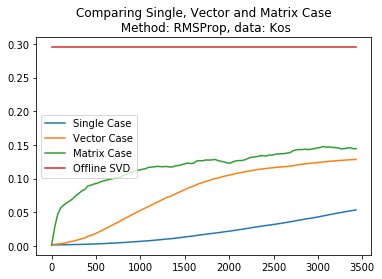

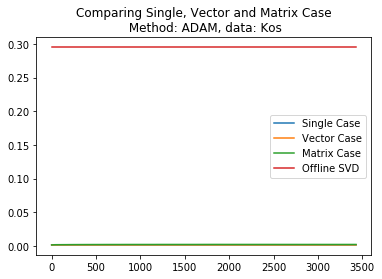

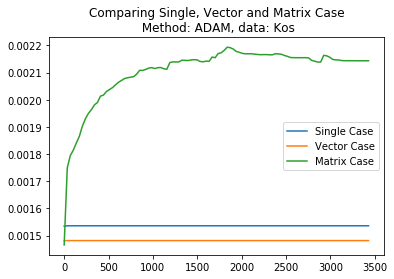

In [8]:
k = 10
B = 1
rmsp0_kos, adam0_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=0, bias_correction=True)
rmsp1_kos, adam1_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1, bias_correction=True)
rmsp2_kos, adam2_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=2, bias_correction=True)

comp_b0_dim(rmsp0_kos, rmsp1_kos, rmsp2_kos, 'Kos', 'RMSProp', true_evar=kos_expvar)
comp_b0_dim(adam0_kos, adam1_kos, adam2_kos, 'Kos', 'ADAM', true_evar=kos_expvar)
comp_b0_dim(adam0_kos, adam1_kos, adam2_kos, 'Kos', 'ADAM')

D:\Ward Research\Code\Proposal Code\streaming_subclass.py:650: RuntimeWarning: overflow encountered in double_scalars
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:650: RuntimeWarning: overflow encountered in true_divide
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:651: RuntimeWarning: invalid value encountered in sqrt
  self.stepvals.append(self.eta/(np.sqrt(self.b0) + self.delta))
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:652: RuntimeWarning: invalid value encountered in sqrt
  self.Q += self.eta / (np.sqrt(self.b0) + self.delta) * self.m0


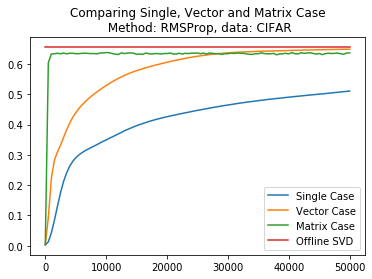

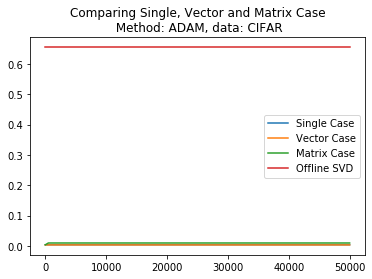

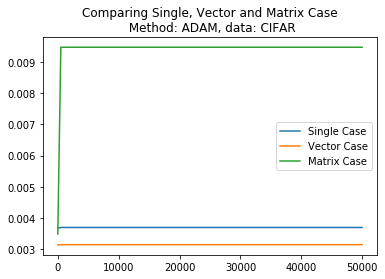

In [9]:

rmsp0_cif, adam0_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, xnorm2=CIFAR_norm2, b0_dim=0, bias_correction=True, Sparse=False)
rmsp1_cif, adam1_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=1, bias_correction=True, Sparse=False)
rmsp2_cif, adam2_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=2, bias_correction=True, Sparse=False)

comp_b0_dim(rmsp0_cif, rmsp1_cif, rmsp2_cif, 'CIFAR', 'RMSProp', true_evar=CIFAR_evar)
comp_b0_dim(adam0_cif, adam1_cif, adam2_cif, 'CIFAR', 'ADAM', true_evar=CIFAR_evar)
comp_b0_dim(adam0_cif, adam1_cif, adam2_cif, 'CIFAR', 'ADAM')


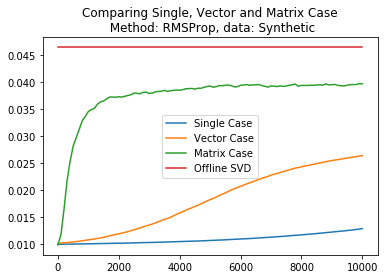

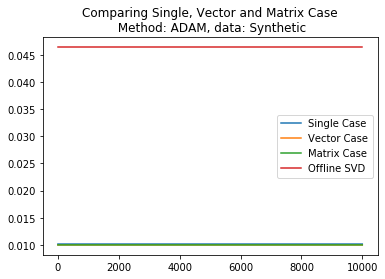

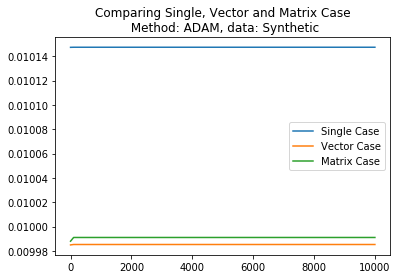

In [10]:
rmsp0_syn, adam0_syn = dssb.run_sim_fullX(syn, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, xnorm2 = syn_norm2, b0_dim=0, bias_correction=True, Sparse=False)
rmsp1_syn, adam1_syn = dssb.run_sim_fullX(syn, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2 = syn_norm2, b0_dim=1, bias_correction=True, Sparse=False)
rmsp2_syn, adam2_syn = dssb.run_sim_fullX(syn, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2 = syn_norm2, b0_dim=2, bias_correction=True, Sparse=False)

comp_b0_dim(rmsp0_syn, rmsp1_syn, rmsp2_syn, 'Synthetic', 'RMSProp', true_evar=syn_evar)
comp_b0_dim(adam0_syn, adam1_syn, adam2_syn, 'Synthetic', 'ADAM', true_evar=syn_evar)
comp_b0_dim(adam0_syn, adam1_syn, adam2_syn, 'Synthetic', 'ADAM')

From the above, we see that the matrix case obtains the best results for RMSProp for our sparse kos dataset. 
Though the matrix case converges more quickly for our dense CIFAR data, the vector case actually achieves better final accuracy. 
For our synthetic data set, the matrix case obtains the best results by a wide margin. 

For ADAM, the overall results are nowhere near the true solution for either the sparse or the dense data. Why?

### Removing Bias Correction Step
One part of ADAM that might be unecessary is *bias correction* which essentially seeks to correct for the fact that $m_0$ and $b_0$ are initialized as vectors of zeros. 
However, this effect may already be mitigated by the normalization step in Oja's method.

Let us modify ADAM and remove the bias correction steps to see if this improves our results:

In [11]:
adam0_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=0, bias_correction=False)
adam1_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1, bias_correction=False)
adam2_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=2, bias_correction=False)

In [12]:
adam0_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, xnorm2=CIFAR_norm2, b0_dim=0, bias_correction=False, Sparse=False)
adam1_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=1, bias_correction=False, Sparse=False)
adam2_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=2, bias_correction=False, Sparse=False)

In [13]:
adam0_syn = dssb.run_sim_fullX(syn, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, b0_dim=0, bias_correction=False, Sparse=False)
adam1_syn = dssb.run_sim_fullX(syn, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, b0_dim=1, bias_correction=False, Sparse=False)
adam2_syn = dssb.run_sim_fullX(syn, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, b0_dim=2, bias_correction=False, Sparse=False)

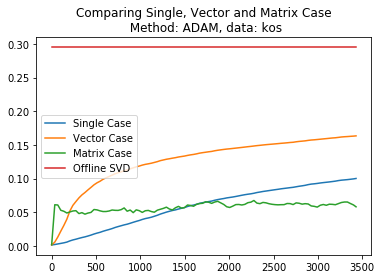

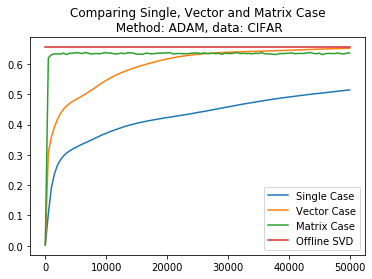

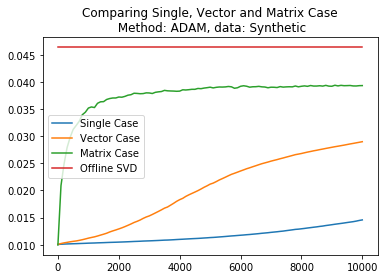

In [14]:
comp_b0_dim(adam0_kos[0], adam1_kos[0], adam2_kos[0], 'kos', 'ADAM', true_evar=kos_expvar)
comp_b0_dim(adam0_cif[0], adam1_cif[0], adam2_cif[0], 'CIFAR', 'ADAM', true_evar=CIFAR_evar)
comp_b0_dim(adam0_syn[0], adam1_syn[0], adam2_syn[0], 'Synthetic', 'ADAM', true_evar=syn_evar)

We see that removing Bias Correction significantly improves our resuts. In the Sparse case, ADAM achieves best performance for vector $b0$ (note that our result is noisy for matrix $b0$. In the dense case, as with RMSProp, the matrix $b0$ converges fastest but the vector $b0$ eventually achieves the overall best accuracy. 

## Evaluating new hyperparameters
Although we seem to obtain somewhat-close to true results for the CIFAR data, our sparse results for the Kos dataset are sadly lacking for both RMSProp and ADAM. 
We consider the effect of the hyperparameter $\eta$ on our convergence results.
We note that the choice of $\eta$ may also explain the difference between our results for the different dimensionalities of $b0$. 
We consider appropriate scaling depending on the $b0\_dim$ parameter as well as the block size $B$. 

In [38]:
# Run adam and rmsprop for the kos data for different parameters. 
eta_vals = 10.**np.arange(-4, 1)
B_vals = [1, 10, 100]
Dim_vals = [0, 1, 2]
Best_eta_kos = np.zeros((2, len(Dim_vals), len(B_vals)))
Final_acc_kos = np.zeros((2, len(Dim_vals), len(B_vals)))

for i in range(len(Dim_vals)):
    for j in range(len(B_vals)):
        rmsp_acc = []
        adam_acc = []
        for eta in eta_vals:
            rmsp_kos, adam_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=eta, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B_vals[j], X=kos_SpX, xnorm2=kos_norm2, b0_dim=Dim_vals[i], bias_correction=False, num_acc=2)
            rmsp_acc.append(rmsp_kos.accQ[-1])
            adam_acc.append(adam_kos.accQ[-1])
        Best_eta_kos[0, i,j] = eta_vals[np.argmax(rmsp_acc)]
        Best_eta_kos[1, i,j] = eta_vals[np.argmax(adam_acc)]
        Final_acc_kos[0, i,j] = np.max(rmsp_acc)
        Final_acc_kos[1, i,j] = np.max(adam_acc)

In [36]:
# Run adam and rmsprop for the synthetic data for different parameters
eta_vals = 10.**np.arange(-4, 1)
B_vals = [1, 10, 100]
Dim_vals = [0, 1, 2]
Best_eta = np.zeros((2, len(Dim_vals), len(B_vals)))
Final_acc = np.zeros((2, len(Dim_vals), len(B_vals)))

for i in range(len(Dim_vals)):
    for j in range(len(B_vals)):
        rmsp_acc = []
        adam_acc = []
        for eta in eta_vals:
            rmsp_syn, adam_syn = dssb.run_sim_fullX(syn, k, methods=['RMSProp', 'ADAM'], eta=eta, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B_vals[j], xnorm2=syn_norm2, b0_dim=Dim_vals[i], bias_correction=False, num_acc=2, Sparse=False)
            rmsp_acc.append(rmsp_syn.accQ[-1])
            adam_acc.append(adam_syn.accQ[-1])
        Best_eta[0, i,j] = eta_vals[np.argmax(rmsp_acc)]
        Best_eta[1, i,j] = eta_vals[np.argmax(adam_acc)]
        Final_acc[0, i,j] = np.max(rmsp_acc)
        Final_acc[1, i,j] = np.max(adam_acc)

In [46]:
# Create dataframes to visualize the results
col = ['B=1', 'B=10', 'B=100']
row = ['b0 dim = 0', 'b0 dim = 1', 'b0 dim = 2']
rmsp_syn_acc = df(Final_acc[0], columns=col, index=row)
adam_syn_acc = df(Final_acc[1], columns=col, index=row)
rmsp_syn_eta = df(Best_eta[0], columns=col, index=row)
adam_syn_eta = df(Best_eta[1], columns=col, index=row)

rmsp_kos_acc = df(Final_acc_kos[0], columns=col, index=row)
adam_kos_acc = df(Final_acc_kos[1], columns=col, index=row)
rmsp_kos_eta = df(Best_eta_kos[0], columns=col, index=row)
adam_kos_eta = df(Best_eta_kos[1], columns=col, index=row)

### Choice of $\eta$ for RMSProp

In the tables below, we display the choice of $\eta$ that achieves the best accuracy for RMSProp for the synthetic (top) and kos (bottom) data sets.
Note that the best scaling for $\eta$ for both the kos and synthetic datasets depends on both the dimension for $b0$ and the blocksize $B$. 
In order to obtain best performance for RMSProp in this setting, we would have to optimize for $\eta$.

In [54]:
display(rmsp_syn_eta)
display(rmsp_kos_eta)

,B=1,B=10,B=100
b0 dim = 0,0.100,0.100,1.00
b0 dim = 1,0.010,0.100,0.10
b0 dim = 2,0.001,0.001,0.01


,B=1,B=10,B=100
b0 dim = 0,0.100,1.000,1.000
b0 dim = 1,0.010,0.100,1.000
b0 dim = 2,0.001,0.001,0.001


### Choice of $\eta$ for ADAM
As with RMSProp, the best scaling for $\eta$ for both the synthetic (top) and kos (bottom) datasets depends on both the dimension for $b0$ and the blocksize $B$. 
Note that for both ADAM and RMSProp, as B increases the best case choice of $\eta$ tends to increase for all $b0$ dimension options. 
On the other hand as the dimension of $b0$ increases the optimal scaling for eta decreases across block sizes. 

In [55]:
display(adam_syn_eta)
display(adam_kos_eta)

,B=1,B=10,B=100
b0 dim = 0,0.0100,0.100,1.00
b0 dim = 1,0.0100,0.010,0.10
b0 dim = 2,0.0001,0.001,0.01


,B=1,B=10,B=100
b0 dim = 0,0.1000,0.1000,1.000
b0 dim = 1,0.0100,0.1000,1.000
b0 dim = 2,0.0001,0.0001,0.001


### Accuracy
#### RMSProp
In the tables below, we display the accuracy from the best choice of $\eta$ for RMSProp on the synthetic dataset (top) and the kos dataset (bottom). 
We see that for $B=1$ the best accuracy was achieved for the vector $b0$ version for both datasets.
For $B=10$ the best accuracy was achieved in the matrix case for the synthetic data and the vector case for the sparse data.
For $B=100$ the best accuracy was achieved in the vector cas--again for both datasets. 
Note that the true explained variance for the kos dataset was $\approx 0.295$ and the closest RMSProp achieved was $\approx 0.2642$ when $B=10$ for the vector case and the true explained variance for the synthetic case was $\approx 0.464$ and the closest RMSProp achieved was $\approx 0.0434$ when $B=100$ for the vector case. 

In [52]:
display(rmsp_syn_acc)
display(rmsp_kos_acc)

,B=1,B=10,B=100
b0 dim = 0,0.038616,0.041453,0.040129
b0 dim = 1,0.043057,0.039668,0.043444
b0 dim = 2,0.039679,0.042797,0.039719


,B=1,B=10,B=100
b0 dim = 0,0.237419,0.222453,0.250771
b0 dim = 1,0.250116,0.264191,0.254136
b0 dim = 2,0.145157,0.102196,0.049941


#### ADAM
We now consider the accuracy from the best choice of $\eta$ for ADAM on the synthetic dataset (top) and the kos dataset (bottom).
Note that we do not correct for bias in these experiments. 
For $B=1$ $b0 dim = 1$ achieves highest accuracy for both datasets.
For $B=10$ $b0 dim = 1$ achieves highest accuracy for the kos dataset and $b0 dim = 2$ achieves highest accuracy on the synthetic dataset. 
For $B=100$ $b0 dim = 1$ achieves highest accuracy for the synthetic dataset and $b0 dim = 0$ achieves highest accuracy for kos, though we note that this accuracy is very close to that achieves for $b0 dim = 1$.
Note that the best accuracies were achieved for $b0 dim = 2, B=10$ and $b0 dim=0, B=100$. 


In [53]:
display(adam_syn_acc)
display(adam_kos_acc)

,B=1,B=10,B=100
b0 dim = 0,0.039338,0.042317,0.042810
b0 dim = 1,0.043334,0.041952,0.043771
b0 dim = 2,0.040116,0.043269,0.041627


,B=1,B=10,B=100
b0 dim = 0,0.249524,0.260289,0.269183
b0 dim = 1,0.264910,0.260604,0.268143
b0 dim = 2,0.091439,0.074031,0.057447


#### Conclusions
For both ADAM and RMSProp, it appears that the most *consistent* results for accuracy are achieved in the vector setting for $b0$. 
We see that there is some variability however. 
It is also important to note that for our sparse data, the matrix case for $b0$ performed terribly for both RMSProp and ADAM.

# Comparing AdaOja to ADAM and RMSProp

Using our values from above, we set $\eta=.1, B=10$ for the kos dataset and $\eta=.1, B=100$ for the synthetic dataset. We visualize the convergence of the explained variance for both datasets:

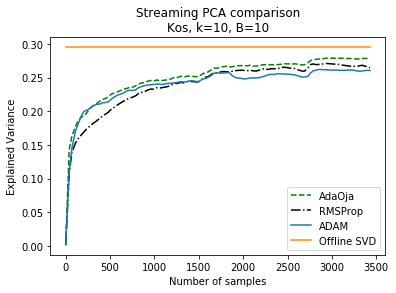

In [59]:
ada_kos, rmsp_kos, adam_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['AdaOja', 'RMSProp', 'ADAM'], eta=.1, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=10, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1, bias_correction=False)
pf.plot_mom_comp(ada_kos, rmsp_kos, adam_kos, 'Kos', true_evar=kos_expvar)

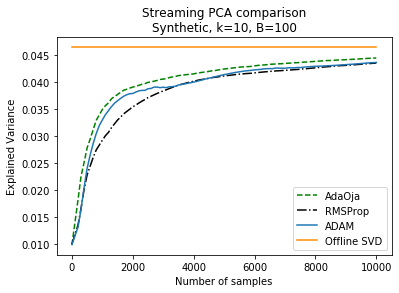

In [60]:
ada_syn, rmsp_syn, adam_syn = dssb.run_sim_fullX(syn, k, methods=['AdaOja', 'RMSProp', 'ADAM'], eta=0.1, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=100, xnorm2=syn_norm2, b0_dim=1, bias_correction=False, Sparse=False)
pf.plot_mom_comp(ada_syn, rmsp_syn, adam_syn, 'Synthetic', true_evar = syn_evar)

When $\eta$ and $B$ are well chosen and bias correction is removed from the ADAM algorithm, we get reasonable convergence results for ADAM and RMSProp as streaming PCA methods. However, we note that AdaOja consistently outperforms ADAM and RMSProp, and requires no such hyperparameter optimization. 

Note that we can also show that AdaOja gets consistent (and better) results--without optimizing for some $\eta$ term--accross choices of blocksize. See below for details. 

In [67]:
for B in B_vals:
    ada_oja = dssb.run_sim_fullX(syn, k, methods=['AdaOja'],  B=B, xnorm2=syn_norm2, num_acc=2, Sparse=False)
    print('B = ' + str(B), 'AdaOja Acc = ' + str(ada_oja[0].accQ[-1]))

B = 1 AdaOja Acc = 0.04392302536961105
B = 10 AdaOja Acc = 0.043955636941666355
B = 100 AdaOja Acc = 0.04433263348055519


In [66]:
for B in B_vals:
    ada_oja = dssb.run_sim_bag('docword.kos.txt', k, methods=['AdaOja'],  B=B, X = kos_SpX, xnorm2=kos_norm2, num_acc=2)
    print('B = ' + str(B), 'AdaOja Acc = ' + str(ada_oja[0].accQ[-1]))

B = 1 AdaOja Acc = 0.2757848696820495
B = 10 AdaOja Acc = 0.2776108007919146
B = 100 AdaOja Acc = 0.2778789849243204
